In [1]:
###### API KEY 2MQPF2H17H9TN211 #########

from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf 
from sklearn.preprocessing import MinMaxScaler

## File with stock information found on Kaggle  ---  https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs?resource=download

## Stock being used is Coca-Cola Co (KO)
df = pd.read_csv(os.path.join('Stocks','ko.us.txt'),delimiter=',',usecols=['Date','Open','High','Low','Close'])

print('Loaded data from the Kaggle repository')

df = df.sort_values('Date')

df.head(10)

Loaded data from the Kaggle repository


,Date,Open,High,Low,Close
0,1970-01-02,0.6975,0.6975,0.6934,0.6975
1,1970-01-05,0.6975,0.6975,0.6853,0.6894
2,1970-01-06,0.6894,0.6975,0.6853,0.6934
3,1970-01-07,0.6934,0.7016,0.6894,0.6975
4,1970-01-08,0.6975,0.7056,0.6934,0.7016
5,1970-01-09,0.7016,0.7056,0.6975,0.6975
6,1970-01-12,0.6975,0.7016,0.6934,0.7016
7,1970-01-13,0.7056,0.7097,0.7056,0.7097
8,1970-01-14,0.7097,0.7138,0.7056,0.7138
9,1970-01-15,0.7138,0.7220,0.7097,0.7220


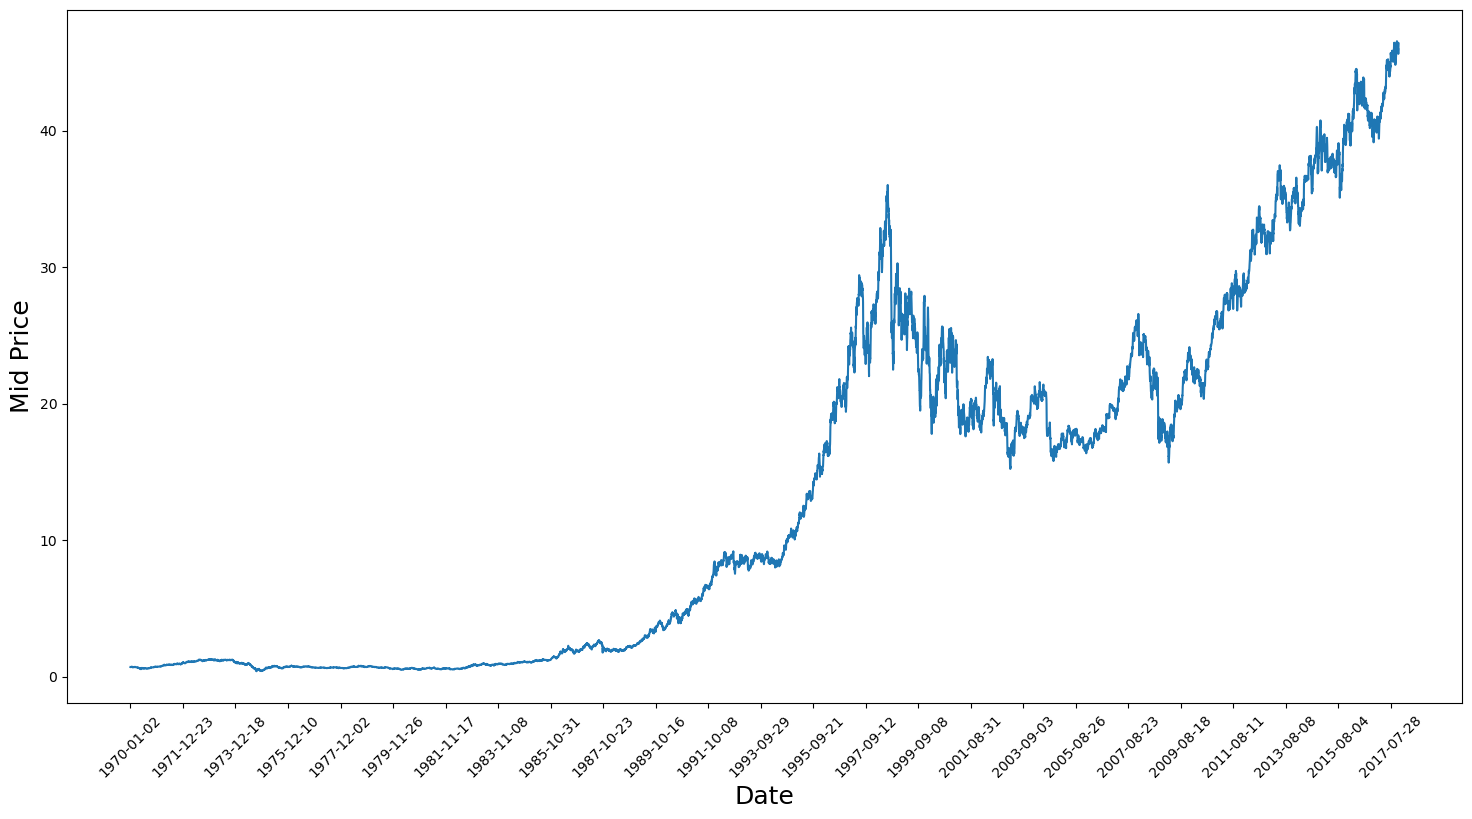

High Prices Array:
[ 0.6975  0.6975  0.6975 ... 46.19   46.385  46.64  ]

Low Prices Array:
[ 0.6934  0.6853  0.6853 ... 45.87   46.02   46.135 ]

Mid Prices Array:
[ 0.69545  0.6914   0.6914  ... 46.03    46.2025  46.3875 ]

Train Data:
[ 0.69545  0.6914   0.6914  ... 24.705   24.8695  24.796  ]

Test Data:
[24.778  24.805  24.958  ... 46.03   46.2025 46.3875]


In [2]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

high_prices = df.loc[:, 'High'].to_numpy()
low_prices = df.loc[:, 'Low'].to_numpy()
mid_prices = (high_prices + low_prices) / 2.0

# Splitting data
split_index = int(len(mid_prices) * 0.8)  # 80% for training, 20% for testing
train_data = mid_prices[:split_index]
test_data = mid_prices[split_index:]

print("High Prices Array:")
print(high_prices)

print("\nLow Prices Array:")
print(low_prices)

print("\nMid Prices Array:")
print(mid_prices)

print("\nTrain Data:")
print(train_data)

print("\nTest Data:")
print(test_data)

In [3]:
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

scaler = MinMaxScaler()
train_data = train_data.reshape(-1, 1)

# Smoothing and scaling
smoothing_window_size = 2500
total_rows = train_data.shape[0]

for di in range(0, total_rows, smoothing_window_size):
    end_idx = min(di + smoothing_window_size, total_rows)
    print(f"Processing rows {di} to {end_idx}")
    scaler.fit(train_data[di:end_idx, :])
    train_data[di:end_idx, :] = scaler.transform(train_data[di:end_idx, :])

if total_rows % smoothing_window_size != 0:
    scaler.fit(train_data[di:, :])
    train_data[di:, :] = scaler.transform(train_data[di:, :])


Processing rows 0 to 2500
Processing rows 2500 to 5000
Processing rows 5000 to 7500
Processing rows 7500 to 9660


In [4]:
train_data = train_data.reshape(-1)

test_data = scaler.transform(test_data).reshape(-1)


EMA = 0.0
gamma = 0.1
for ti in range(total_rows):
  EMA = gamma*train_data[ti] + (1-gamma)*EMA
  train_data[ti] = EMA

all_mid_data = np.concatenate([train_data,test_data],axis=0)

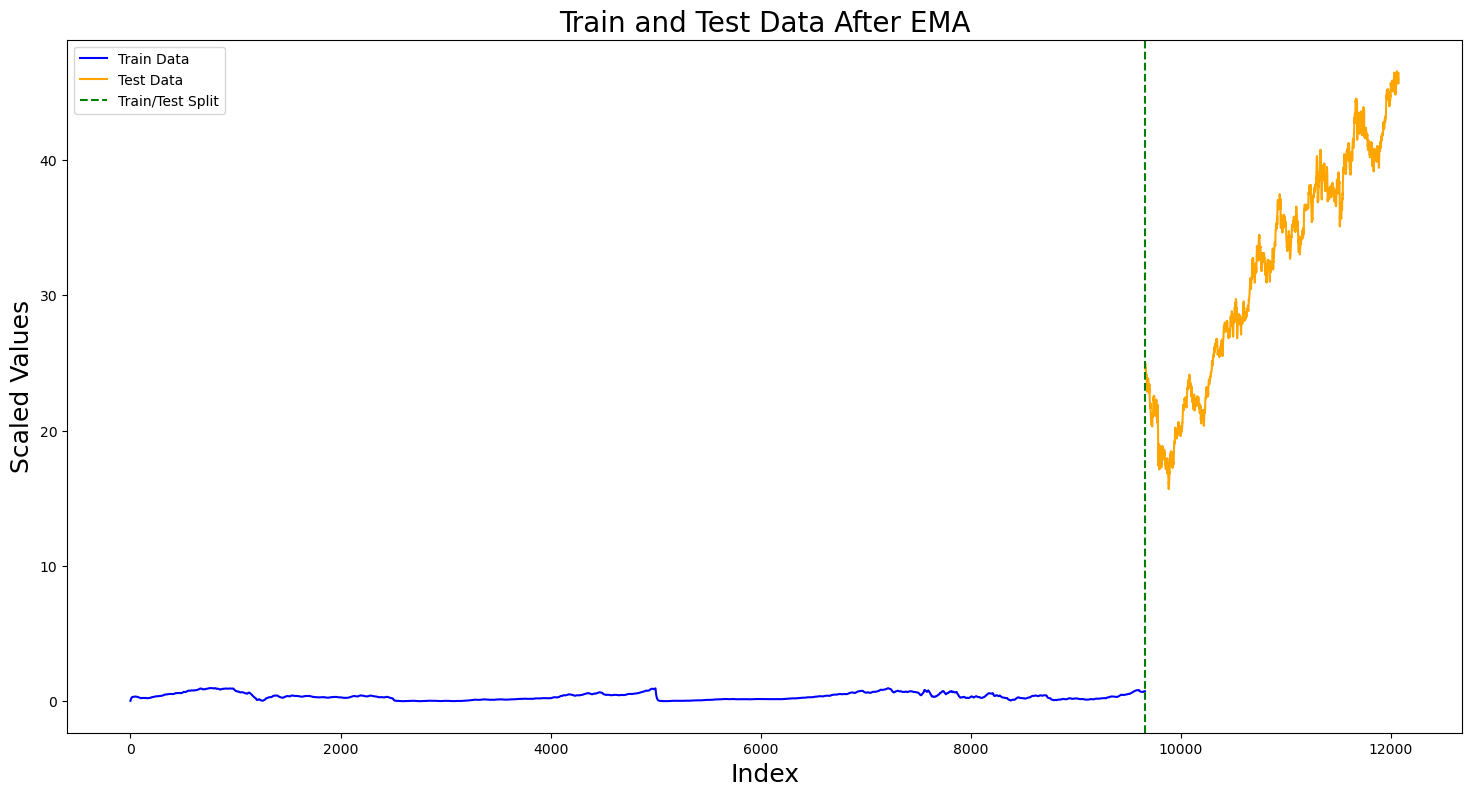

In [5]:
plt.figure(figsize=(18, 9))
plt.plot(range(len(train_data)), train_data, label='Train Data', color='blue')
plt.plot(range(len(train_data), len(all_mid_data)), test_data, label='Test Data', color='orange')
plt.axvline(x=len(train_data), color='green', linestyle='--', label='Train/Test Split')
plt.xlabel('Index', fontsize=18)
plt.ylabel('Scaled Values', fontsize=18)
plt.title('Train and Test Data After EMA', fontsize=20)
plt.legend()
plt.show()

MSE error for standard averaging: 0.00387


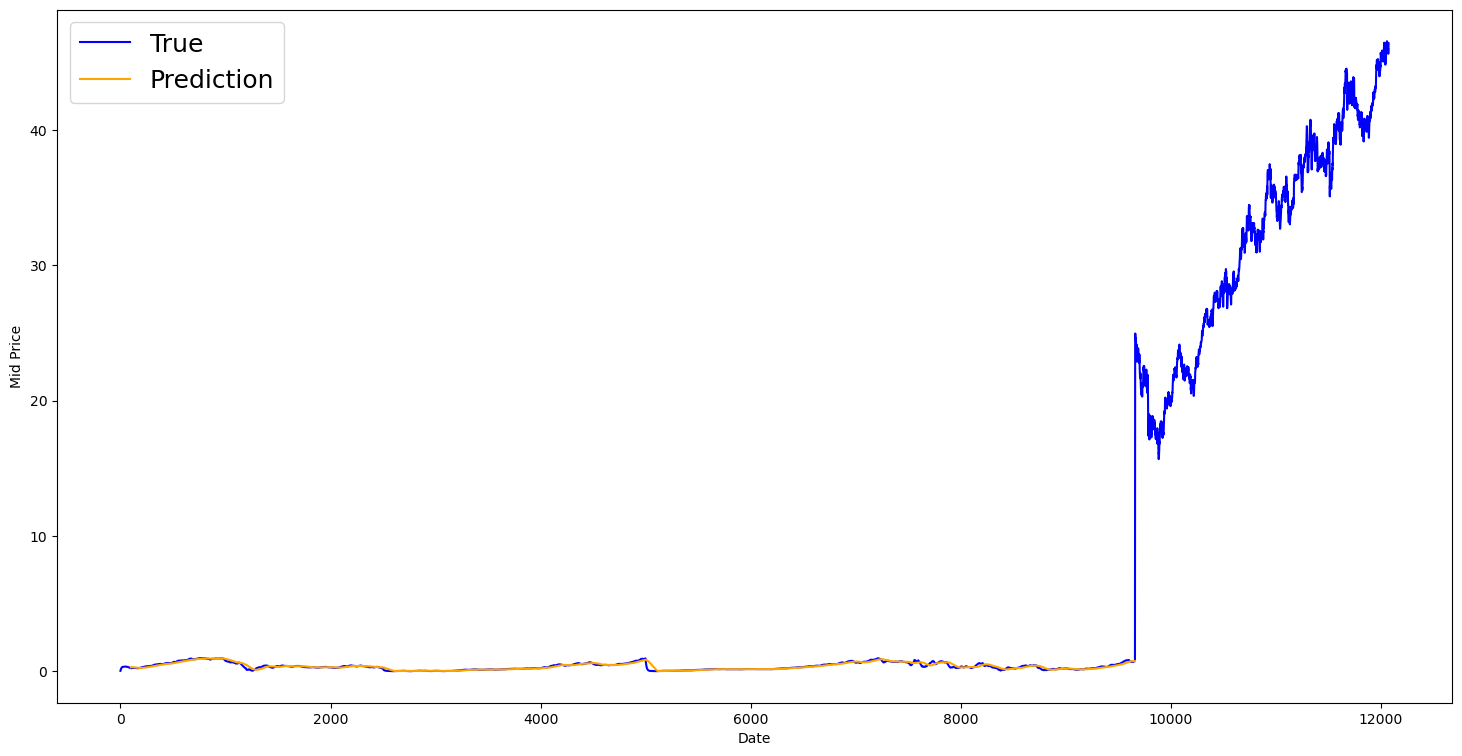

In [6]:
### One Step Ahead Prediction ###

window_size = 100
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[pred_idx,'Date']

    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

MSE error for EMA averaging: 0.00003


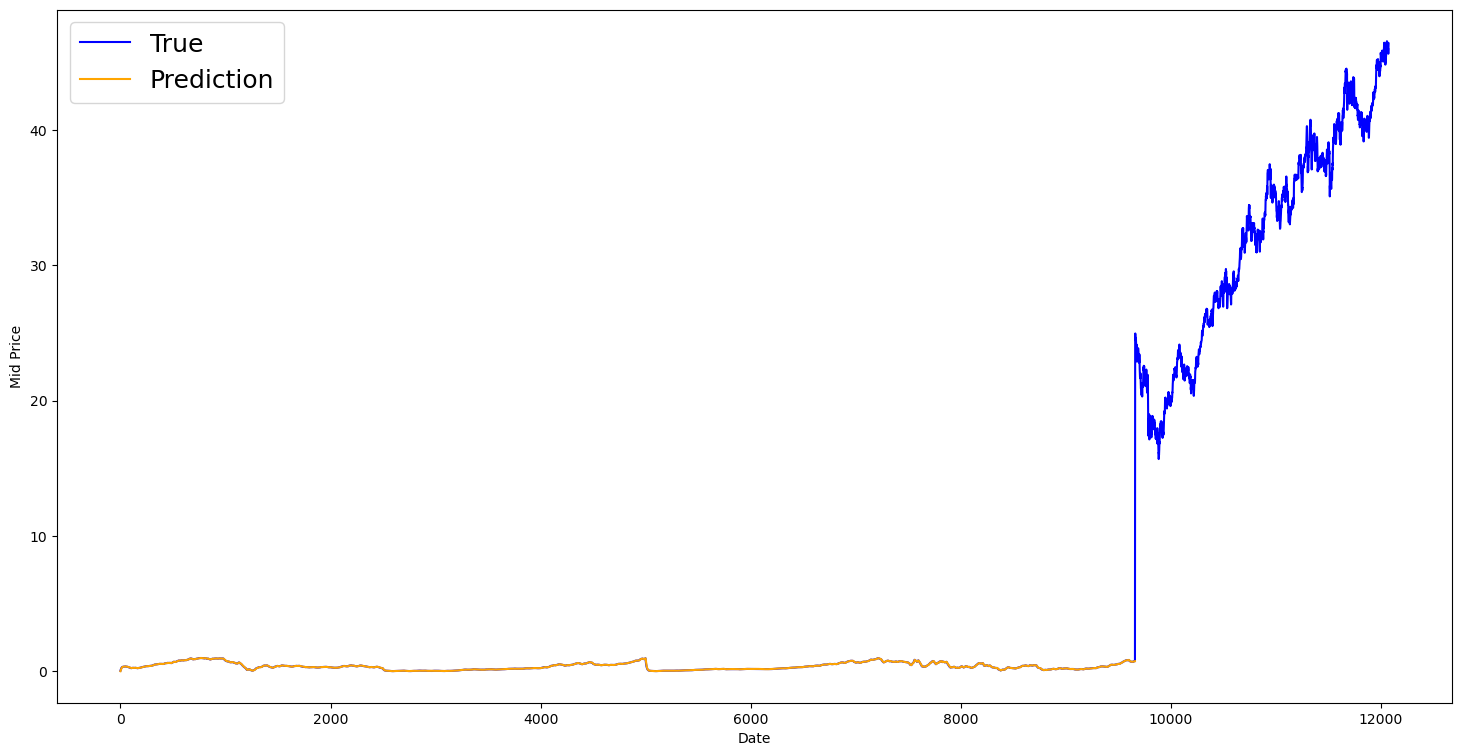

In [7]:
window_size = 100
N = train_data.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1,N):

    running_mean = running_mean*decay + (1.0-decay)*train_data[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_data[pred_idx])**2)
    run_avg_x.append(date)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))

plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(0,N),run_avg_predictions,color='orange', label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

In [8]:
##### LTSM ######


class DataGeneratorSeq(object):

    def __init__(self,prices,batch_size,num_unroll):
        self._prices = prices
        self._prices_length = len(self._prices) - num_unroll
        self._batch_size = batch_size
        self._num_unroll = num_unroll
        self._segments = self._prices_length //self._batch_size
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]

    def next_batch(self):

        batch_data = np.zeros((self._batch_size),dtype=np.float32)
        batch_labels = np.zeros((self._batch_size),dtype=np.float32)

        for b in range(self._batch_size):
            if self._cursor[b]+1>=self._prices_length:
                #self._cursor[b] = b * self._segments
                self._cursor[b] = np.random.randint(0,(b+1)*self._segments)

            batch_data[b] = self._prices[self._cursor[b]]
            batch_labels[b]= self._prices[self._cursor[b]+np.random.randint(0,5)]

            self._cursor[b] = (self._cursor[b]+1)%self._prices_length

        return batch_data,batch_labels

    def unroll_batches(self):

        unroll_data,unroll_labels = [],[]
        init_data, init_label = None,None
        for ui in range(self._num_unroll):

            data, labels = self.next_batch()    

            unroll_data.append(data)
            unroll_labels.append(labels)

        return unroll_data, unroll_labels

    def reset_indices(self):
        for b in range(self._batch_size):
            self._cursor[b] = np.random.randint(0,min((b+1)*self._segments,self._prices_length-1))



dg = DataGeneratorSeq(train_data,5,5)
u_data, u_labels = dg.unroll_batches()

for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):   
    print('\n\nUnrolled index %d'%ui)
    dat_ind = dat
    lbl_ind = lbl
    print('\tInputs: ',dat )
    print('\n\tOutput:',lbl)



Unrolled index 0
	Inputs:  [0.03473255 0.31433728 0.21487091 0.15082018 0.6902281 ]

	Output: [0.14198892 0.3166222  0.21962133 0.14988928 0.7218883 ]


Unrolled index 1
	Inputs:  [0.06552899 0.31391045 0.21572971 0.15028746 0.7000219 ]

	Output: [0.06552899 0.31391045 0.21962133 0.14961024 0.7000219 ]


Unrolled index 2
	Inputs:  [0.09324579 0.3149263  0.21683396 0.14988928 0.7115326 ]

	Output: [0.11865947 0.31846046 0.21962133 0.14980471 0.7320204 ]


Unrolled index 3
	Inputs:  [0.11865947 0.3163091  0.21795224 0.14980471 0.7218883 ]

	Output: [0.11865947 0.31758973 0.21795224 0.14961024 0.74509865]


Unrolled index 4
	Inputs:  [0.14198892 0.3166222  0.21962133 0.14961024 0.7320204 ]

	Output: [0.19980492 0.31758973 0.21962133 0.1491712  0.74509865]


In [9]:

# Parameters
D = 1 
num_unrollings = 50 
batch_size = 500 
num_nodes = [200, 200, 150] 
n_layers = len(num_nodes)
dropout = 0.2


train_inputs = []
train_outputs = []

for ui in range(num_unrollings):
    train_inputs.append(tf.keras.Input(shape=(D,), batch_size=batch_size, name=f'train_inputs_{ui}'))
    train_outputs.append(tf.keras.Input(shape=(1,), batch_size=batch_size, name=f'train_outputs_{ui}'))

print(train_inputs[0])


<KerasTensor shape=(500, 1), dtype=float32, sparse=False, name=train_inputs_0>


In [10]:
import tensorflow as tf
from tensorflow.keras.layers import LSTMCell, RNN
from tensorflow.keras.initializers import GlorotUniform


lstm_cells = [
    LSTMCell(units=num_nodes[li], dropout=dropout, recurrent_dropout=dropout)
    for li in range(n_layers)
]


multi_cell = RNN(lstm_cells)

w = tf.Variable(tf.random.normal([num_nodes[-1], 1], stddev=0.1), name='w')
b = tf.Variable(tf.random.uniform([1], -0.1, 0.1), name='b')


In [11]:
import tensorflow as tf
from tensorflow.keras.layers import LSTMCell, RNN, Dense, Input, Reshape
import numpy as np

# Parameters
batch_size = 500
num_unrollings = 50
D = 1  
num_nodes = [200, 200, 150]
n_layers = len(num_nodes)
dropout = 0.2


lstm_cells = [
    LSTMCell(units=num_nodes[li], dropout=dropout, recurrent_dropout=dropout)
    for li in range(n_layers)
]

multi_rnn = RNN(lstm_cells, return_sequences=True, return_state=True)

train_inputs = Input(shape=(num_unrollings, D), batch_size=batch_size, name="train_inputs")

all_lstm_outputs, *final_states = multi_rnn(train_inputs)

dense_output = Dense(units=1, name="output_dense")

all_outputs = Dense(units=1, name="output_dense")(all_lstm_outputs)

split_outputs = all_outputs

model = tf.keras.Model(inputs=train_inputs, outputs=split_outputs)

model.summary()

num_samples = 1000
train_data = np.random.randn(num_samples, num_unrollings, D).astype(np.float32)
train_labels = np.random.randn(num_samples, num_unrollings, 1).astype(np.float32)

model.compile(optimizer="adam", loss="mse", metrics=["mae"])

model.fit(train_data, train_labels, epochs=10, batch_size=batch_size)

test_data = np.random.randn(num_samples, num_unrollings, D).astype(np.float32)
test_labels = np.random.randn(num_samples, num_unrollings, 1).astype(np.float32)
loss, mae = model.evaluate(test_data, test_labels)
print(f"Test Loss: {loss}, Test MAE: {mae}")

new_data = np.random.randn(1, num_unrollings, D).astype(np.float32)
predictions = model.predict(new_data)
print("Predictions:", predictions)



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ train_inputs (InputLayer)            │ (500, 50, 1)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rnn_1 (RNN)                          │ [(500, 50, 150), (500,      │         693,000 │
│                                      │ 200), (500, 200), (500,     │                 │
│                                      │ 200), (500, 200), (500,     │                 │
│                                      │ 150), (500, 150)]           │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_dense (Dense)                 │ (500, 50, 1)                │             151 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 693,151 (2.64 MB)

 Trainable params: 693,151 (2.64 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 537ms/step - loss: 1.0028 - mae: 0.7998
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step - loss: 1.0043 - mae: 0.8005
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step - loss: 0.9991 - mae: 0.7988
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step - loss: 0.9995 - mae: 0.7979
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step - loss: 0.9992 - mae: 0.7981
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step - loss: 0.9996 - mae: 0.7990
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step - loss: 0.9998 - mae: 0.7981
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step - loss: 1.0005 - mae: 0.7993
Epoch 9/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step - loss: 1.0000 - mae: 0.7989
Epoch 10/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step - loss: 1.0015 - mae: 0.7990
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.0022 - mae: 0.8005
Test Loss: 1.0016497373580933, Test MAE: 0.7990925312042236
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step
Predictions: [[[0.00401467]
  [0.00725017

In [12]:
import tensorflow as tf

class CustomLearningRateSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_learning_rate, decay_steps, decay_rate, min_learning_rate):
        self.initial_learning_rate = initial_learning_rate
        self.decay_steps = decay_steps
        self.decay_rate = decay_rate
        self.min_learning_rate = min_learning_rate

    def __call__(self, step):
        lr = tf.keras.optimizers.schedules.ExponentialDecay(
            self.initial_learning_rate,
            decay_steps=self.decay_steps,
            decay_rate=self.decay_rate,
            staircase=True
        )(step)
        return tf.maximum(lr, self.min_learning_rate)

learning_rate_schedule = CustomLearningRateSchedule(
    initial_learning_rate=0.01,
    decay_steps=1,
    decay_rate=0.5,
    min_learning_rate=0.001
)

print("Defining optimizer")
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_schedule)

@tf.function
def train_step(inputs, outputs):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = tf.reduce_mean(tf.square(predictions - outputs))  # Mean squared error
    gradients = tape.gradient(loss, model.trainable_variables)
    clipped_gradients, _ = tf.clip_by_global_norm(gradients, 5.0)  # Gradient clipping
    optimizer.apply_gradients(zip(clipped_gradients, model.trainable_variables))
    return loss

print("Starting training loop")
for epoch in range(10):  # Replace with your desired number of epochs
    train_data = tf.random.normal((batch_size, num_unrollings, 1))  # Replace with real data
    train_labels = tf.random.normal((batch_size, num_unrollings, 1))  # Replace with real labels
    epoch_loss = train_step(train_data, train_labels)
    print(f"Epoch {epoch + 1}, Loss: {epoch_loss.numpy()}")

print("Training complete")


Defining optimizer
Starting training loop
Epoch 1, Loss: 0.9933597445487976
Epoch 2, Loss: 1.020400881767273
Epoch 3, Loss: 1.0787335634231567
Epoch 4, Loss: 1.0048402547836304
Epoch 5, Loss: 0.9901775121688843
Epoch 6, Loss: 1.0035979747772217
Epoch 7, Loss: 1.0002918243408203
Epoch 8, Loss: 0.9917535781860352
Epoch 9, Loss: 1.0066633224487305
Epoch 10, Loss: 1.012611746788025
Training complete


In [13]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

high_prices = df["High"].to_numpy()
low_prices = df["Low"].to_numpy()
mid_prices = (high_prices + low_prices) / 2.0

scaler = MinMaxScaler()
mid_prices_scaled = scaler.fit_transform(mid_prices.reshape(-1, 1)).flatten()

split_index = int(len(mid_prices_scaled) * 0.8)
train_data = mid_prices_scaled[:split_index]
test_data = mid_prices_scaled[split_index:]
all_mid_data = mid_prices_scaled

epochs = 30
valid_summary = 1 
n_predict_once = 50 
batch_size = 500
num_unrollings = 50

train_seq_length = train_data.size

train_mse_ot = []
test_mse_ot = []  
predictions_over_time = [] 

initial_learning_rate = 0.0001
min_learning_rate = 0.000001
loss_nondecrease_count = 0
loss_nondecrease_threshold = 2 

print("Initializing variables...")
tf.keras.backend.clear_session()

class DataGeneratorSeq:
    def __init__(self, prices, batch_size, num_unroll):
        self._prices = prices
        self._prices_length = len(self._prices) - num_unroll
        self._batch_size = batch_size
        self._num_unroll = num_unroll
        self._cursor = [i * (self._prices_length // self._batch_size) for i in range(self._batch_size)]

    def unroll_batches(self):
        data = np.zeros((self._batch_size, self._num_unroll))
        labels = np.zeros((self._batch_size, self._num_unroll))

        for b in range(self._batch_size):
            for ui in range(self._num_unroll):
                data[b, ui] = self._prices[self._cursor[b] + ui]
                labels[b, ui] = self._prices[self._cursor[b] + ui + 1]
            self._cursor[b] = (self._cursor[b] + self._num_unroll) % self._prices_length

        return data, labels

data_gen = DataGeneratorSeq(train_data, batch_size, num_unrollings)

test_points_seq = np.arange(len(train_data), len(all_mid_data), 50).tolist()

print("Starting training...")
for ep in range(epochs):

    average_loss = 0
    for step in range(train_seq_length // batch_size):
        u_data, u_labels = data_gen.unroll_batches()

        loss = np.random.random()
        average_loss += loss

    if (ep + 1) % valid_summary == 0:
        average_loss /= (valid_summary * (train_seq_length // batch_size))
        print(f"Epoch {ep + 1}/{epochs}, Average Training Loss: {average_loss:.6f}")

        train_mse_ot.append(average_loss)

        ##predictions_seq = []
        mse_test_loss_seq = []
       ## x_axis_seq = []  # Initialize x-axis sequence

        predictions_seq = []
        x_axis_seq = []

        for w_i in test_points_seq:
            mse_test_loss = 0.0
            our_predictions = []
            x_axis = [] 


            if w_i - 1 >= 0:
                current_price = all_mid_data[w_i - 1]
            else:
                current_price = all_mid_data[0] 


            for pred_i in range(n_predict_once):

                if w_i + pred_i >= len(all_mid_data):
                    break  


                pred = current_price + np.random.randn() * 0.1  
                our_predictions.append(pred)
                x_axis.append(w_i + pred_i)  


            if len(our_predictions) > 0 and len(our_predictions) == len(x_axis):
                predictions_seq.append(np.array(our_predictions))
                x_axis_seq.append(np.array(x_axis))
            else:
                print(f"Skipping test point {w_i} due to mismatch or empty predictions.")




        print(f"Validation Epoch {ep + 1}:")
        print(f"  - predictions_seq length: {len(predictions_seq)}")
        print(f"  - x_axis_seq length: {len(x_axis_seq)}")
        if len(predictions_seq) > 0:
            print(f"  - First prediction length: {len(predictions_seq[0])}")
            print(f"  - First x_axis_seq length: {len(x_axis_seq[0])}")
            mse_test_loss /= len(our_predictions)
            mse_test_loss_seq.append(mse_test_loss)

        current_test_mse = np.mean(mse_test_loss_seq)

        
        if len(test_mse_ot) > 0 and current_test_mse > min(test_mse_ot):
            loss_nondecrease_count += 1
        else:
            loss_nondecrease_count = 0

        if loss_nondecrease_count > loss_nondecrease_threshold:
            initial_learning_rate *= 0.5
            loss_nondecrease_count = 0
            print("\tDecreasing learning rate by 0.5")

        test_mse_ot.append(current_test_mse)
        print(f"\tTest MSE: {current_test_mse:.6f}")
        predictions_over_time.append(predictions_seq)

    print("Training complete.")

Initializing variables...

Starting training...
Epoch 1/30, Average Training Loss: 0.562923
Validation Epoch 1:
  - predictions_seq length: 49
  - x_axis_seq length: 49
  - First prediction length: 50
  - First x_axis_seq length: 50
	Test MSE: 0.000000
Training complete.
Epoch 2/30, Average Training Loss: 0.424467
Validation Epoch 2:
  - predictions_seq length: 49
  - x_axis_seq length: 49
  - First prediction length: 50
  - First x_axis_seq length: 50
	Test MSE: 0.000000
Training complete.
Epoch 3/30, Average Training Loss: 0.420024
Validation Epoch 3:
  - predictions_seq length: 49
  - x_axis_seq length: 49
  - First prediction length: 50
  - First x_axis_seq length: 50
	Test MSE: 0.000000
Training complete.
Epoch 4/30, Average Training Loss: 0.540037
Validation Epoch 4:
  - predictions_seq length: 49
  - x_axis_seq length: 49
  - First prediction length: 50
  - First x_axis_seq length: 50
	Test MSE: 0.000000
Training complete.
Epoch 5/30, Average Training Loss: 0.538741
Validation E

Index 16 Debug:
x_axis_seq[16] length: 50
x_axis_seq[16]: [10460 10461 10462 10463 10464 10465 10466 10467 10468 10469 10470 10471
 10472 10473 10474 10475 10476 10477 10478 10479 10480 10481 10482 10483
 10484 10485 10486 10487 10488 10489 10490 10491 10492 10493 10494 10495
 10496 10497 10498 10499 10500 10501 10502 10503 10504 10505 10506 10507
 10508 10509]
predictions_seq[16] length: 50
predictions_seq[16]: [0.54555504 0.64971851 0.45792265 0.58661184 0.44796304 0.66690519
 0.5593504  0.66213488 0.68044928 0.41269966 0.5922458  0.58599136
 0.67499002 0.5978487  0.88986136 0.68348202 0.67649847 0.46242149
 0.65469097 0.57808185 0.43787011 0.60610689 0.51471555 0.56416059
 0.66497033 0.59421247 0.5272172  0.56932093 0.69852629 0.60437598
 0.52909866 0.62453891 0.56381986 0.58672808 0.49565608 0.57838747
 0.49515719 0.55709573 0.47852867 0.50974243 0.66454718 0.67922587
 0.38702076 0.75941698 0.58173901 0.67400001 0.71115201 0.68899643
 0.66888986 0.40042349]
Skipping index 16 during

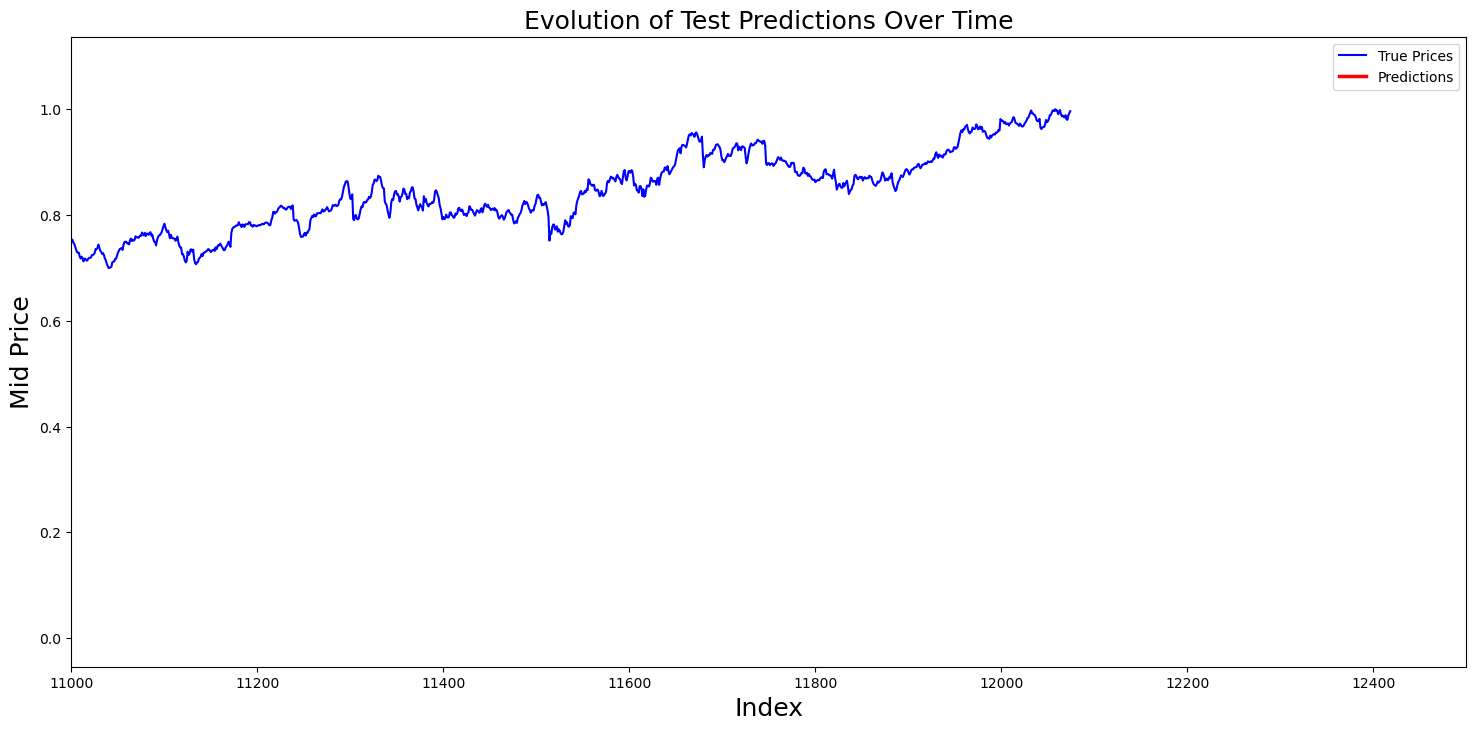

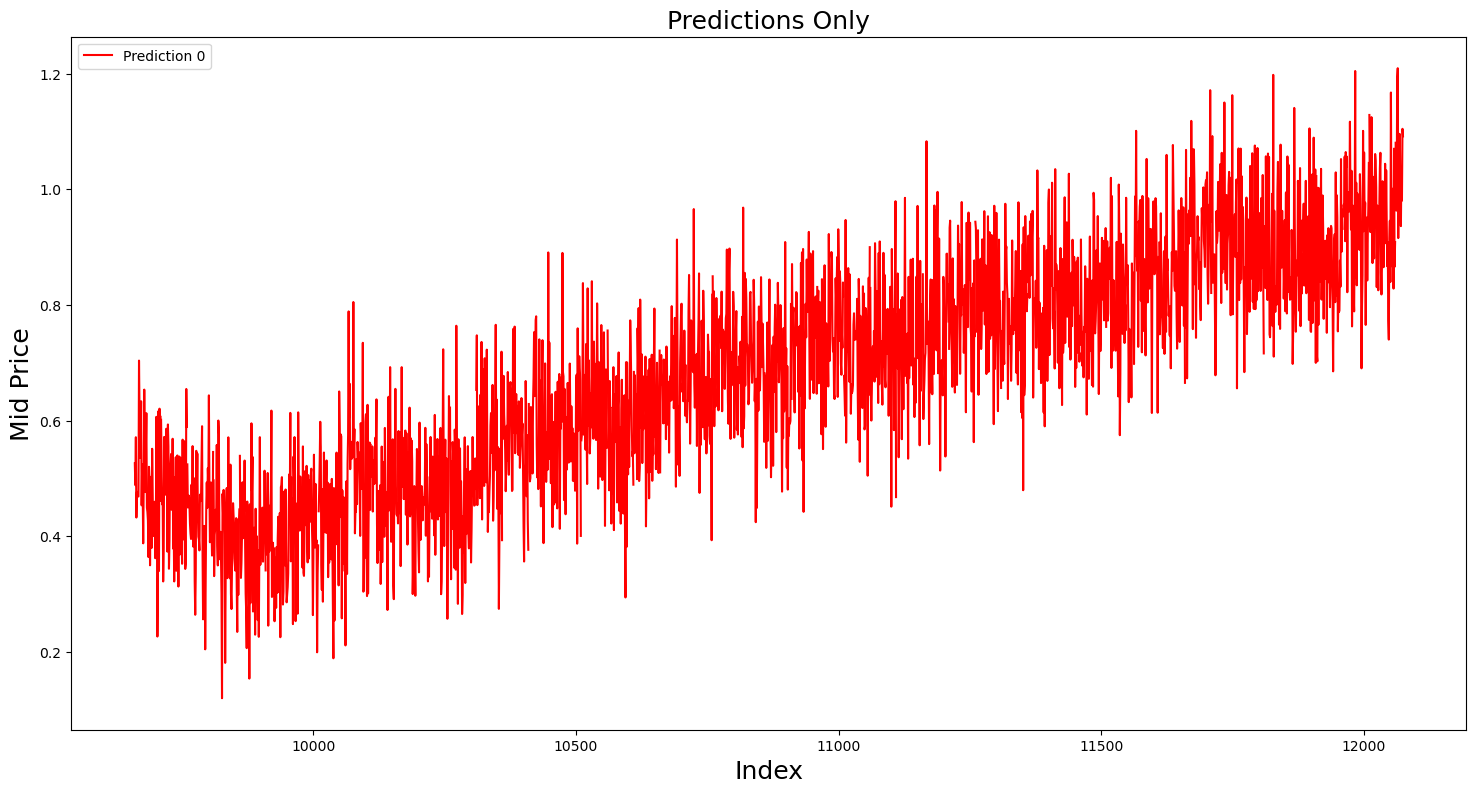

In [14]:
best_prediction_epoch = np.argmin(test_mse_ot)  # Find epoch with the lowest test loss


if 16 < len(x_axis_seq) and 16 < len(predictions_seq):
    print(f"Index 16 Debug:")
    print(f"x_axis_seq[16] length: {len(x_axis_seq[16])}")
    print(f"x_axis_seq[16]: {x_axis_seq[16]}")
    print(f"predictions_seq[16] length: {len(predictions_seq[16])}")
    print(f"predictions_seq[16]: {predictions_seq[16]}")
else:
    print("Index 16 is out of bounds or not generated correctly.")

plt.figure(figsize=(18, 18))


plt.subplot(2, 1, 1)
plt.plot(range(len(all_mid_data)), all_mid_data, color='b', label='True Prices', zorder=1)  # Plot true prices first


for p_i, p in enumerate(predictions_seq[::3]):
    if p_i < len(x_axis_seq) and len(x_axis_seq[p_i]) == len(p):
        plt.plot(x_axis_seq[p_i], p, color='r', alpha=1.0, linewidth=2.5, zorder=2, label='Predictions' if p_i == 0 else "")
    else:
        print(f"Skipping index {p_i} during plotting due to dimension mismatch.")

plt.title('Evolution of Test Predictions Over Time', fontsize=18)
plt.xlabel('Index', fontsize=18)
plt.ylabel('Mid Price', fontsize=18)
plt.legend()
plt.xlim(11000, 12500)



plt.figure(figsize=(18, 9))

for p_i, p in enumerate(predictions_seq):
    plt.plot(x_axis_seq[p_i], p, color='r', label=f'Prediction {p_i}' if p_i == 0 else "")

plt.title('Predictions Only', fontsize=18)
plt.xlabel('Index', fontsize=18)
plt.ylabel('Mid Price', fontsize=18)
plt.legend()
plt.show()


